In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error


In [2]:
df = pd.read_csv('datasets/dengue_features_train.csv', parse_dates=[3])
target = pd.read_csv('datasets/dengue_labels_train.csv')

# add total cases into df
df['total_cases'] = target['total_cases']

# create new datasets

df_sj = df[df['city'] == 'sj']
df_iq = df[df['city'] == 'iq']

## FrontFill to Impute into Missing values

df_sj = df_sj.fillna(method = 'ffill')
df_iq = df_iq.fillna(method = 'ffill')

# set index to the dates
df_sj.set_index('week_start_date', drop = True, inplace = True)
df_iq.set_index('week_start_date', drop = True, inplace = True)

#drop non-numerical values
df_sj.drop(['city', 'year'], axis = 1, inplace = True)
df_iq.drop(['city', 'year'], axis = 1, inplace = True)

In [4]:
print(df_sj.head())
df_iq.to_pickle('datasets/df_iq.pkl')
df_sj.to_pickle('datasets/df_sj.pkl')

                 weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
week_start_date                                                       
1990-04-30               18  0.122600  0.103725  0.198483  0.177617   
1990-05-07               19  0.169900  0.142175  0.162357  0.155486   
1990-05-14               20  0.032250  0.172967  0.157200  0.170843   
1990-05-21               21  0.128633  0.245067  0.227557  0.235886   
1990-05-28               22  0.196200  0.262200  0.251200  0.247340   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                
1990-04-30                      12.42             297.572857   
1990-05-07                      22.82             298.211429   
1990-05-14                      34.54             298.781429   
1990-05-21                      15.36             298.987143   
1990-05-28                       7.52             299.518571   

                 reanalysis_avg_temp_k  reanalysis_de

In [8]:
# read in pickled features
df_sj = pd.read_pickle('datasets/all_sj.pkl')
df_iq = pd.read_pickle('datasets/all_iq.pkl')

total_cases = pd.read_csv('datasets/dengue_labels_train.csv')
# create only total cases colomn
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

In [15]:
print(df_sj.index)

DatetimeIndex(['1990-04-30', '1990-05-07', '1990-05-14', '1990-05-21',
               '1990-05-28', '1990-06-04', '1990-06-11', '1990-06-18',
               '1990-06-25', '1990-07-02',
               ...
               '2013-02-19', '2013-02-26', '2013-03-05', '2013-03-12',
               '2013-03-19', '2013-03-26', '2013-04-02', '2013-04-09',
               '2013-04-16', '2013-04-23'],
              dtype='datetime64[ns]', name='week_start_date', length=1196, freq=None)


In [13]:
# train test split
#sj

# choose split dates
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = cases_sj[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = cases_sj[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test


In [16]:
#iq

# choose split dates
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' # this will split between pre and post submission dates

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_Xtrain = iq_train
iq_ytrain = cases_iq[:len(iq_Xtrain)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = cases_iq[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]

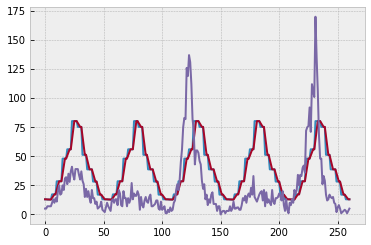

In [48]:
# sj monthly trend

lr_sj = LinearRegression()
X = pd.get_dummies(sj_Xtrain['month'], prefix='month')
y = sj_ytrain.values

lr_sj.fit(X, y)
# window of rolling 3
monthly_trend_train = pd.Series(lr_sj.predict(X)).rolling(3, min_periods = 1).mean()
sj_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(sj_Xvalid['month'], prefix='month')
ytest = sj_yvalid.values
monthly_trend_valid = pd.Series(lr_sj.predict(Xtest)).rolling(3, min_periods=1).mean()
sj_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_sj.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

-16.28448275862069
675 261


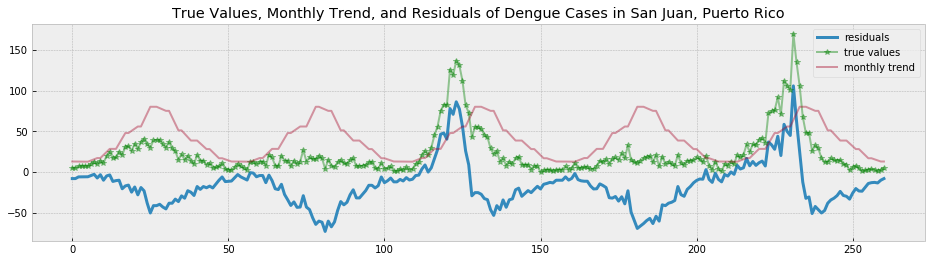

In [49]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(sj_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in San Juan, Puerto Rico')
plt.legend()
print (np.mean(sj_residuals_test))

print (len(sj_residuals_train), len(sj_residuals_test))

34.72577715
-0.812111334176


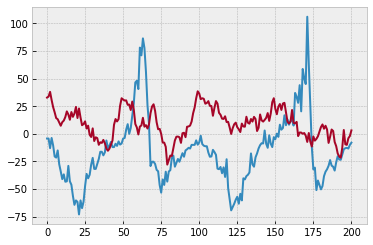

In [64]:
# munge data

# max roll back set to 59

# rolling means df
Xtrain_temp_means = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:675]
Xtrain_ndvi_means = df_sj['ndvi_se'].rolling(window = 10).mean()[60:675]

Xtrain = pd.concat([Xtrain_ndvi_means], axis=1)
ytrain = sj_residuals_train[60:]

# rolling means df
Xvalid_temp_means = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[675:936]
Xvalid_ndvi_means = df_sj['ndvi_se'].rolling(window = 10).mean()[675:936]

# combine all dfs
Xvalid = pd.concat([Xvalid_ndvi_means], axis = 1)[60:]
yvalid = sj_residuals_test[60:]


# fit on model, predict
lr_sj_residual = LinearRegression()
lr_sj_residual.fit(Xtrain, ytrain)

sj_valid_preds = lr_sj_residual.predict(Xvalid)

print (mean_absolute_error(sj_valid_preds, yvalid))
print (lr_sj_residual.score(Xvalid, yvalid))
plt.plot(yvalid.values)
plt.plot(sj_valid_preds)

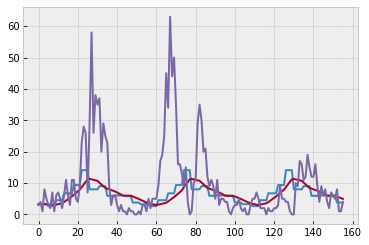

7.0661005661
6.93198985208


In [66]:
# iq monthly trend

lr_iq = LinearRegression()
X = pd.get_dummies(iq_Xtrain['month'], prefix='month')
y = iq_ytrain.values

lr_iq.fit(X, y)
monthly_trend_train = pd.Series(lr_iq.predict(X)).rolling(9, min_periods = 1).mean()
iq_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(iq_Xvalid['month'], prefix='month')
ytest = iq_yvalid.values
monthly_trend_valid = pd.Series(lr_iq.predict(Xtest)).rolling(9, min_periods=1).mean()
iq_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_iq.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print (mean_absolute_error(lr_iq.predict(Xtest), ytest))
print (mean_absolute_error(monthly_trend_valid, ytest))

3.4354563591170657


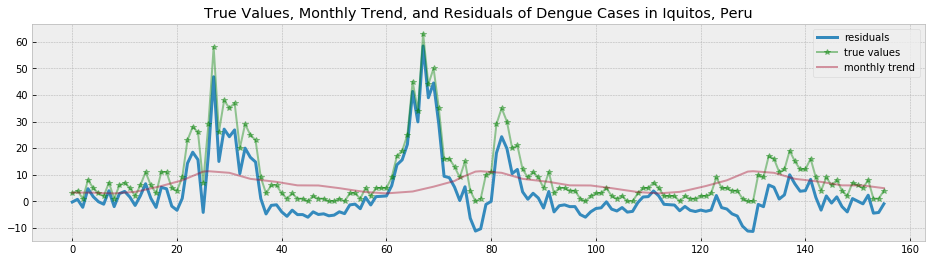

In [68]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(iq_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in Iquitos, Peru')
plt.legend()
print (np.mean(iq_residuals_test))

0.0477535417336
7.86391827097


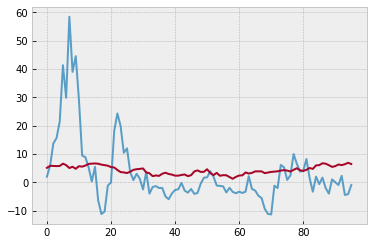

In [80]:
# rolling mean of feature to predict residuals

# munge data

# max roll back set to 59

# set up training data
# rolling means df
Xtrain_means1 = df_iq['ndvi_nw'].rolling(window = 53).mean()[60:364]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_train[60:]

# print len(Xtrain), len(ytrain)

# set up validation data
# rolling means df
Xvalid_means1 = df_iq['ndvi_nw'].rolling(window = 53).mean()[364:520]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = iq_residuals_test[60:]

# print len(Xvalid), len(yvalid)

# model it!

lr_iq_resids = LinearRegression()
lr_iq_resids.fit(Xtrain, ytrain)

iq_valid_preds = lr_iq_resids.predict(Xvalid)

# plot iq residual predictions
plt.plot(yvalid.values, alpha = .80)
plt.plot(iq_valid_preds)
print (lr_iq_resids.score(Xvalid, yvalid))
print (mean_absolute_error(iq_valid_preds, yvalid))

936 876


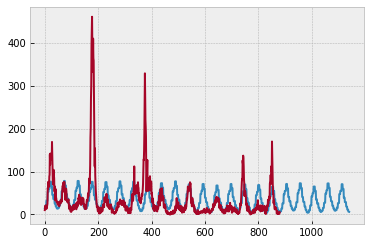

In [90]:
# transform sj data

month_dums = pd.get_dummies(df_sj['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_sj[['reanalysis_air_temp_k']].rolling(window = 55).mean())
# temp_roll_std = pd.DataFrame(df_sj[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test set
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)
# train model
lr_sj_full = LinearRegression()
lr_sj_full.fit(Xtest[60:-260], cases_sj.values[60:])

print(len(cases_sj),len(Xtest[60:-260]))
# predicts
sj_full_preds = lr_sj_full.predict(Xtest[55:])
sj_submit_preds = sj_full_preds[-260:]
plt.plot(sj_full_preds)
plt.plot(cases_sj.values[55:])
plt.show()

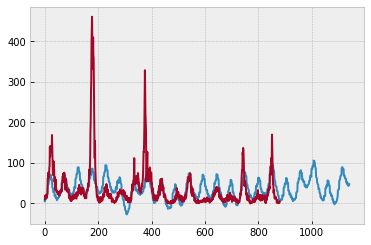

In [91]:
# transform iq data
month_dums = pd.get_dummies(df_iq['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_iq[['ndvi_mean']].rolling(window = 68).mean())
# temp_roll_std = pd.DataFrame(df_iq[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train
lr_iq_full = LinearRegression()
lr_iq_full.fit(Xtest[68:-156], cases_iq.values[68:])

# predicts
iq_full_preds = lr_iq_full.predict(Xtest[68:])
iq_submit_preds = iq_full_preds[-156:]

In [92]:
total_preds = list(sj_submit_preds) + list(iq_submit_preds)

submission_format = pd.read_csv('datasets/submission_format.csv')

submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

submission_format.to_csv('submissions/LFR1.csv', index=False)